## PROBLEM STATEMENT

### The objective of this Machine Learning Model is:

● To predict the payment date of an invoice when it gets created in the system.

● Categorize the invoice into different buckets based on predicted payment date.

> Invoice for the goods contains various information like the details of the goods purchased and when it should be paid.

This is a standard Regression task. Below is the dataset attributes with description.

Invoice No | Due Date |  Actual Open Amt | Payment Date | Aging Bucket
----------------|------------|--------------|-------------------|----------------------
1001 | 03/12/2020 | 9000 | 14/02/2021 | > 60 days
1002 | 10/12/2020 | 5000 | 23/12/2020 | 0-15 days
1003 | 17/12/2020 | 3000 | 16/01/2021 | 31-45 days

In [1]:
import numpy as np       
import pandas as pd      
import seaborn as sns    
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn import metrics
import warnings

In [2]:
# Reading the data from the dataset.

df = pd.read_csv(r'Invoice_dataset.csv')

In [111]:
# Shows the first five column of the dataset.

df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0200769623,WAL-MAR co,2020-01-21 00:00:00,2020.0,1.930376e+09,2020-01-09,20200108,20200109,20200124.0,USD,RV,1.0,NaN,13442.81,20200109.0,NAH4,1.930376e+09,0
1,U001,0200705372,FR trust,2019-09-05 00:00:00,2019.0,1.929442e+09,2019-06-07,20190605,20190607,20190905.0,USD,RV,1.0,NaN,1395.64,20190607.0,NAVR,1.929442e+09,0
2,CA02,0140106408,WAL-M,2019-10-10 00:00:00,2019.0,2.960582e+09,2019-09-24,20190924,20190924,20191004.0,CAD,RV,1.0,NaN,23701.50,20190924.0,CA10,2.960582e+09,0
3,U001,CCCA02,KRAFT llc,2019-03-29 00:00:00,2019.0,1.928684e+09,2019-01-27,20190125,20190127,20190303.0,USD,RV,1.0,NaN,40128.00,20190127.0,NAG2,1.928684e+09,0
4,U001,0200735528,ASSOCIA corporation,2019-05-23 00:00:00,2019.0,1.929260e+09,2019-05-07,20190505,20190507,20190522.0,USD,RV,1.0,NaN,123785.42,20190507.0,NAA8,1.929260e+09,0


In [112]:
# Identifies the number of rows and columns.

df.shape

(50000, 19)

In [113]:
# Shows the information of the dataset.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   business_code           50000 non-null  object 
 1   cust_number             50000 non-null  object 
 2   name_customer           50000 non-null  object 
 3   clear_date              45442 non-null  object 
 4   buisness_year           50000 non-null  float64
 5   doc_id                  50000 non-null  float64
 6   posting_date            50000 non-null  object 
 7   document_create_date    50000 non-null  int64  
 8   document_create_date.1  50000 non-null  int64  
 9   due_in_date             50000 non-null  float64
 10  invoice_currency        50000 non-null  object 
 11  document type           50000 non-null  object 
 12  posting_id              50000 non-null  float64
 13  area_business           0 non-null      float64
 14  total_open_amount       50000 non-null

In [114]:
# Shows the number of unique entries in each column.

df.nunique()

business_code                 5
cust_number                1431
name_customer              4260
clear_date                  398
buisness_year                 2
doc_id                    50000
posting_date                501
document_create_date        506
document_create_date.1      502
due_in_date                 544
invoice_currency              2
document type                 2
posting_id                    1
area_business                 0
total_open_amount         45307
baseline_create_date        503
cust_payment_terms           75
invoice_id                49993
isOpen                        2
dtype: int64

#  Converting dates to datetime datatype-
> Getting dates into a friendly format and extracting features of dates into new variables can be useful preprocessing steps.

In [115]:
# Observed that the date columns have differnt data types, so it is needed to convert them to datetime data type
# using "to_datetime function".

df['clear_date']             = pd.to_datetime(df['clear_date'])      
df['posting_date']           = pd.to_datetime(df['posting_date'])      
df['document_create_date']   = pd.to_datetime(df['document_create_date'],format='%Y%m%d') 
df['document_create_date.1'] = pd.to_datetime(df['document_create_date.1'],format='%Y%m%d')   
df['due_in_date']            = pd.to_datetime(df['due_in_date'],format='%Y%m%d')              
df['baseline_create_date']   = pd.to_datetime(df['baseline_create_date'],format='%Y%m%d')     

# dt.year ->  returns the year of the date time.
df["buisness_year"]          =pd.to_datetime(df["buisness_year"],format='%Y').dt.year         

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   business_code           50000 non-null  object        
 1   cust_number             50000 non-null  object        
 2   name_customer           50000 non-null  object        
 3   clear_date              45442 non-null  datetime64[ns]
 4   buisness_year           50000 non-null  int64         
 5   doc_id                  50000 non-null  float64       
 6   posting_date            50000 non-null  datetime64[ns]
 7   document_create_date    50000 non-null  datetime64[ns]
 8   document_create_date.1  50000 non-null  datetime64[ns]
 9   due_in_date             50000 non-null  datetime64[ns]
 10  invoice_currency        50000 non-null  object        
 11  document type           50000 non-null  object        
 12  posting_id              50000 non-null  float6

#### We can observe that the data types have been changed accordingly.

# Finding & Removing Anomalies 
## Sanity Check
> Test to quickly evaluate whether a claim or the result of a calculation can possibly be true.

In [117]:
# baseline_create_date -> date in which the invoice is created.
# due_in_date -> date in which the customer is expected to clear an invoice.

print("Here we are Checking if the due_in_date is of before baseline_create_date") 
print("Found: ",df[df["baseline_create_date"] > df.due_in_date]["due_in_date"].count()) 

# clear_date -> invoice is clear that day. 
# document_create_date -> invoice is created that day. 

print("Checking if clear_date is of before document_created_date.1") 
print("Found: ",df[df["document_create_date.1"] > df.clear_date]["clear_date"].count())

# total_open_amount -> amount left to be paid which cannot be <0.

print("Checking if total_open_amount<0") 
print("Found: ",df[df.total_open_amount < 0 ]["total_open_amount"].count())

Here we are Checking if the due_in_date is of before baseline_create_date
Found:  0
Checking if clear_date is of before document_created_date.1
Found:  0
Checking if total_open_amount<0
Found:  0


## Creating a seperate dataframe for rows having null clear data or open invoices. We shall use it later for predicting the payment

In [118]:
open_invoice_df = df[df["clear_date"].isna()]    # returns a boolean object indicating if the values are NA.
df = df[df["clear_date"].notna()]                # returns a boolean object indicating if the values are not NA.
df.reset_index(inplace=True)                     # resetting the index having null value.

In [119]:
open_invoice_df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
45442,U001,0200956366,RICH trust,NaT,2020,1.930757e+09,2020-04-08,2020-04-06,2020-04-08,2020-04-23,USD,RV,1.0,NaN,40494.96,2020-04-08,NAA8,1.930757e+09,1
45443,U001,0200769623,WAL-MAR us,NaT,2020,1.930567e+09,2020-02-27,2020-02-25,2020-02-27,2020-03-13,USD,RV,1.0,NaN,16892.00,2020-02-27,NAH4,1.930567e+09,1
45444,U001,0100031704,DELHAIZE co,NaT,2020,1.930740e+09,2020-04-05,2020-04-03,2020-04-05,2020-04-20,USD,RV,1.0,NaN,15150.77,2020-04-05,NAA8,1.930740e+09,1
45445,U001,0200416837,DEC corporation,NaT,2020,1.930672e+09,2020-03-20,2020-03-20,2020-03-20,2020-04-08,USD,RV,1.0,NaN,66.48,2020-03-16,NAM4,1.930672e+09,1
45446,U001,0100044010,LAND foundation,NaT,2020,1.930794e+09,2020-04-16,2020-04-16,2020-04-16,2020-05-18,USD,RV,1.0,NaN,46238.85,2020-04-16,NA32,1.930794e+09,1


# Creating the target column

In [120]:
# dt.days ->  returns the number of days of the date time.
# Creating a new column to keep the number of delays.

df["delay"] = (df["clear_date"] - df["due_in_date"]).dt.days

In [121]:
# We are sorting the dataframe acording to the document_create_date.1.

df = df.sort_values(by="document_create_date.1",ignore_index=True)

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45442 entries, 0 to 45441
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   index                   45442 non-null  int64         
 1   business_code           45442 non-null  object        
 2   cust_number             45442 non-null  object        
 3   name_customer           45442 non-null  object        
 4   clear_date              45442 non-null  datetime64[ns]
 5   buisness_year           45442 non-null  int64         
 6   doc_id                  45442 non-null  float64       
 7   posting_date            45442 non-null  datetime64[ns]
 8   document_create_date    45442 non-null  datetime64[ns]
 9   document_create_date.1  45442 non-null  datetime64[ns]
 10  due_in_date             45442 non-null  datetime64[ns]
 11  invoice_currency        45442 non-null  object        
 12  document type           45442 non-null  object

In [123]:
# There are 45442 rows. We shall make the train set to be 70% of this ->  0.7 * 45442
# iloc is for selecting rows and columns by integer position.

df.iloc[31809]

index                                   38596
business_code                            U001
cust_number                        0200769623
name_customer                     WAL-MAR llc
clear_date                2019-10-18 00:00:00
buisness_year                            2019
doc_id                            1.92998e+09
posting_date              2019-10-08 00:00:00
document_create_date      2019-10-07 00:00:00
document_create_date.1    2019-10-08 00:00:00
due_in_date               2019-10-23 00:00:00
invoice_currency                          USD
document type                              RV
posting_id                                  1
area_business                             NaN
total_open_amount                     1549.78
baseline_create_date      2019-10-08 00:00:00
cust_payment_terms                       NAH4
invoice_id                        1.92998e+09
isOpen                                      0
delay                                      -5
Name: 31809, dtype: object

# Splitting the dataset according to Date

In [124]:
# document_create_date -> 2019-10-07 (for 70%)
# For training set we should take "document_create_date" < 2019-10-01

train=df[df['document_create_date'] < '2019-10-01'].copy()
test=df[df['document_create_date'] >= '2019-10-01'].reset_index(drop=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14356 entries, 0 to 14355
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   index                   14356 non-null  int64         
 1   business_code           14356 non-null  object        
 2   cust_number             14356 non-null  object        
 3   name_customer           14356 non-null  object        
 4   clear_date              14356 non-null  datetime64[ns]
 5   buisness_year           14356 non-null  int64         
 6   doc_id                  14356 non-null  float64       
 7   posting_date            14356 non-null  datetime64[ns]
 8   document_create_date    14356 non-null  datetime64[ns]
 9   document_create_date.1  14356 non-null  datetime64[ns]
 10  due_in_date             14356 non-null  datetime64[ns]
 11  invoice_currency        14356 non-null  object        
 12  document type           14356 non-null  object

In [125]:
# It shows the number of rows and columns in the train part.
train.shape

(31086, 21)

In [126]:
# It shows the number of rows and columns in the test part.
test.shape

(14356, 21)

In [127]:
# Information regarding the train set.

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31086 entries, 0 to 32239
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   index                   31086 non-null  int64         
 1   business_code           31086 non-null  object        
 2   cust_number             31086 non-null  object        
 3   name_customer           31086 non-null  object        
 4   clear_date              31086 non-null  datetime64[ns]
 5   buisness_year           31086 non-null  int64         
 6   doc_id                  31086 non-null  float64       
 7   posting_date            31086 non-null  datetime64[ns]
 8   document_create_date    31086 non-null  datetime64[ns]
 9   document_create_date.1  31086 non-null  datetime64[ns]
 10  due_in_date             31086 non-null  datetime64[ns]
 11  invoice_currency        31086 non-null  object        
 12  document type           31086 non-null  object

# EDA - Exploratory Data Analysis 
> To analyze and investigate data sets and summarize their main characteristics.

> Meant to uncover the underlying structure of a data set.

> It exposes trends, patterns, and relationships that are not readily apparent.

## Removing Constant and Quasi constant data

In [128]:
# Identifies the number of unique entries in each column in the train set.

train.nunique()

index                     31086
business_code                 5
cust_number                1284
name_customer              3532
clear_date                  288
buisness_year                 1
doc_id                    31086
posting_date                282
document_create_date        278
document_create_date.1      283
due_in_date                 342
invoice_currency              2
document type                 2
posting_id                    1
area_business                 0
total_open_amount         28449
baseline_create_date        289
cust_payment_terms           68
invoice_id                31079
isOpen                        1
delay                       180
dtype: int64

In [129]:
# Finding the duplicates in the trainset.

train.duplicated().sum()

0

It is concluded that there is no duplicates found.

In [130]:
# Describes the trainset.

train.describe()

,index,buisness_year,doc_id,posting_id,area_business,total_open_amount,invoice_id,isOpen,delay
count,31086.000000,31086.0,3.108600e+04,31086.0,0.0,31086.000000,3.107900e+04,31086.0,31086.000000
mean,22763.428360,2019.0,2.012938e+09,1.0,NaN,31855.013460,2.011251e+09,0.0,1.163643
std,13102.739952,0.0,2.988683e+08,0.0,NaN,39620.403268,2.769719e+08,0.0,11.445376
min,1.000000,2019.0,1.928502e+09,1.0,NaN,0.860000,1.928502e+09,0.0,-85.000000
25%,11459.250000,2019.0,1.928984e+09,1.0,NaN,4624.417500,1.928983e+09,0.0,-3.000000
50%,22769.500000,2019.0,1.929402e+09,1.0,NaN,17159.755000,1.929402e+09,0.0,0.000000
75%,34120.750000,2019.0,1.929750e+09,1.0,NaN,45979.360000,1.929750e+09,0.0,2.000000
max,45441.000000,2019.0,9.500000e+09,1.0,NaN,723760.430000,2.960583e+09,0.0,268.000000


In [131]:
# Dropping this constant and quasi constant columns because it is of no use in dataset as it does not add any new feature.
# A column is constant if nunique() == 1

train.drop(["buisness_year","isOpen","posting_id","area_business"],axis=1,inplace=True)

# Checking correlation among numeric colmns
>Correlation is a statistic that measures the degree to which two variables move in relation to each other

['index', 'doc_id', 'total_open_amount', 'invoice_id', 'delay']


<AxesSubplot:>

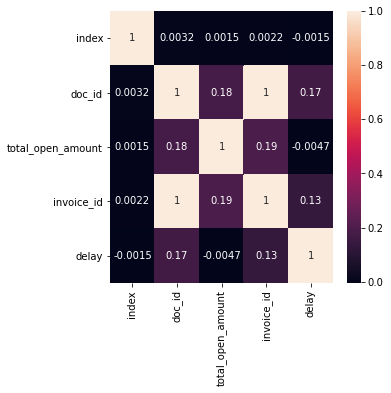

In [132]:
numerical_columns=train.select_dtypes(include=np.number).columns.tolist()
print(numerical_columns)
correlation=train.corr()
plt.subplots(figsize=(5,5))        
sns.heatmap(correlation,annot=True) #annot — when set to True, the correlation values become visible on the colored cells.


>It is clearly visible that "doc_id" and "invoice_id" are perfectly correlated.

>Correlated columns convey similar information to the learning algorithm and therefore, should be removed.

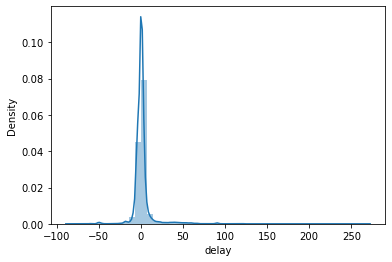

In [133]:
sns.distplot(train['delay'])
warnings.filterwarnings('ignore')

# Plotting the delay .

In [134]:
# Checking the correlation of delay with other columns.

train.corr().loc['delay',:]

index               -0.001491
doc_id               0.169868
total_open_amount   -0.004712
invoice_id           0.133974
delay                1.000000
Name: delay, dtype: float64

> Negative correlation is a relationship between two variables in which one variable increases as the other decreases, and vice versa

In [135]:
# As mentioned above, dropping these columns.

train.drop(["doc_id","invoice_id"],axis=1,inplace=True)

In [136]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31086 entries, 0 to 32239
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   index                   31086 non-null  int64         
 1   business_code           31086 non-null  object        
 2   cust_number             31086 non-null  object        
 3   name_customer           31086 non-null  object        
 4   clear_date              31086 non-null  datetime64[ns]
 5   posting_date            31086 non-null  datetime64[ns]
 6   document_create_date    31086 non-null  datetime64[ns]
 7   document_create_date.1  31086 non-null  datetime64[ns]
 8   due_in_date             31086 non-null  datetime64[ns]
 9   invoice_currency        31086 non-null  object        
 10  document type           31086 non-null  object        
 11  total_open_amount       31086 non-null  float64       
 12  baseline_create_date    31086 non-null  dateti

Text(0.5, 1.0, 'Count')

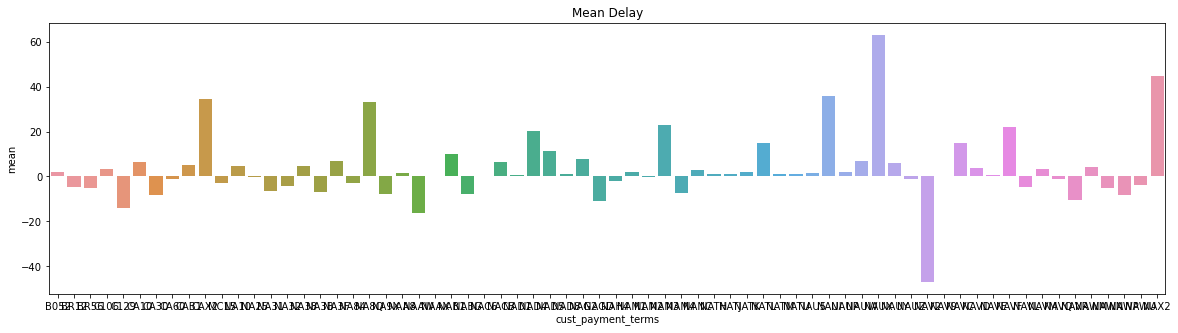

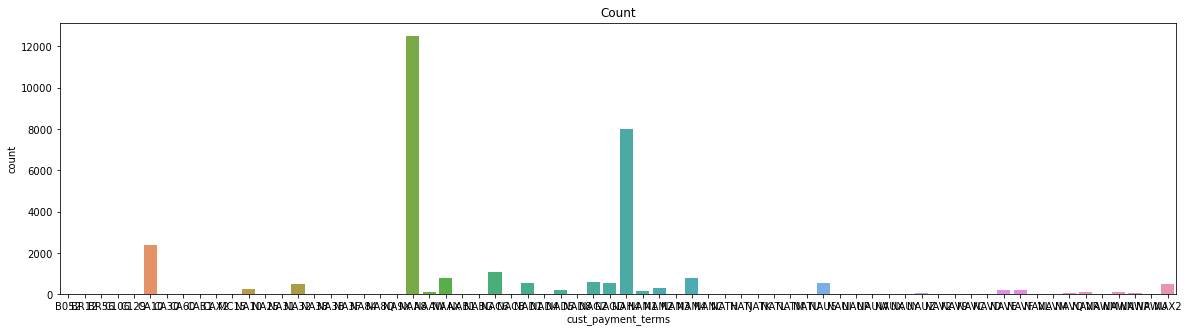

In [137]:
payment_terms = train.groupby("cust_payment_terms")["delay"].agg(["mean","count"]).reset_index(drop=False)
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x='cust_payment_terms',y='mean',data=payment_terms).set_title("Mean Delay")
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x='cust_payment_terms',y='count',data=payment_terms).set_title("Count")

It is observed that the mean delay varies with the cust_payment_score and is not dependent on the frequency.

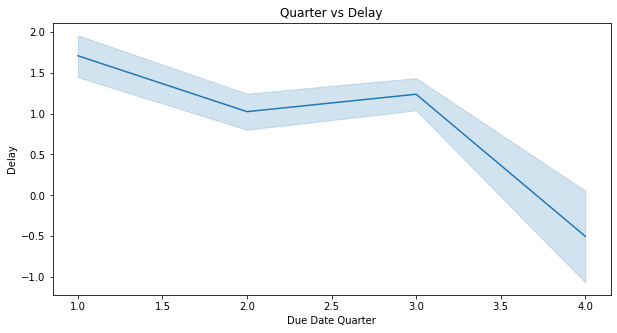

In [138]:
# Checking Relation between Delay and Quarter

plt.figure(figsize=(10,5))
sns.lineplot(x=train["due_in_date"].dt.quarter, y=train.delay)
plt.xlabel("Due Date Quarter")
plt.ylabel("Delay")
plt.title("Quarter vs Delay")
plt.show()

It is observed that the delay is high in the first two quarters and payments are early in the last quarter

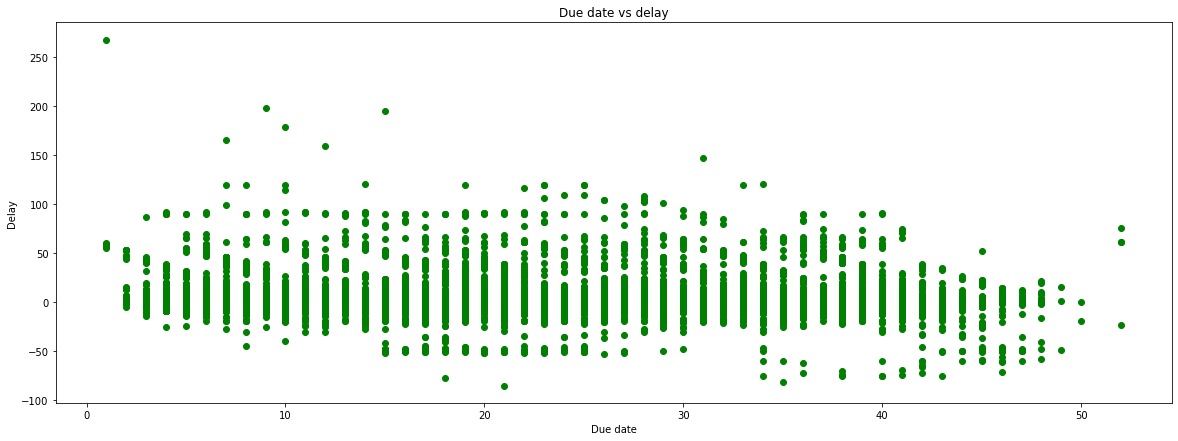

In [139]:
# Checking relation between delay and week of year

plt.figure(figsize=(20,7))
plt.scatter(np.array(train["due_in_date"].dt.isocalendar().week), train.delay,color='g')
plt.xlabel("Due date")
plt.ylabel("Delay")
plt.title("Due date vs delay")
plt.show()


It is noticed that the delays are high in the first 3 weeks of the year and the last 2 weeks of the year

In [140]:
# Now Analysing the catagorical columns

cat_columns=list(train.columns[train.dtypes=='object'])
train[cat_columns].nunique()

business_code            5
cust_number           1284
name_customer         3532
invoice_currency         2
document type            2
cust_payment_terms      68
dtype: int64

In [145]:
print("Business Codes:   ",train.business_code.unique())       # Checking all unique business code , only 5 types are there.

print("Invoice currency: ",train.invoice_currency.unique())    # Checking invoice currency available , it is observed only 2 types are there.
                                                               # It can be cateogarised into binary column: "isUSD"

print("Document type:    ",train['document type'].unique())    # Checking the document type , only 2 types ate there.


Business Codes:    ['CA02' 'U001' 'U013' 'U002' 'U005']
Invoice currency:  ['CAD' 'USD']
Document type:     ['X2' 'RV']


In [142]:
print(train.invoice_currency.value_counts())   # Counts the number of invoice_currency in USD and CAD.

print(train['document type'].value_counts())   # Counts the number of documents in RV and X2 type.

USD    28643
CAD     2443
Name: invoice_currency, dtype: int64
RV    31079
X2        7
Name: document type, dtype: int64


<AxesSubplot:>

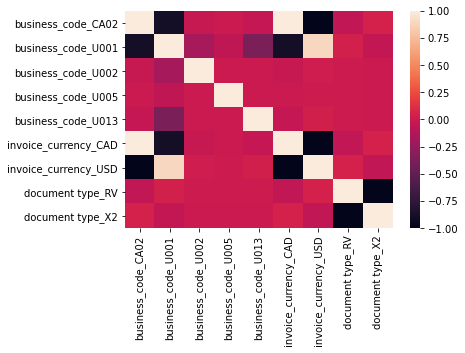

In [143]:
cat_corr = pd.get_dummies(train[["business_code","invoice_currency","document type"]]).corr()
sns.heatmap(cat_corr)

# heatmap showing correlation.

In [144]:
# cust_payment_terms -> Business terms and agreements between customers and accounts on discounts and days of payment.

key = set(train["cust_payment_terms"])
value = list(range(1,len(key)+1))

mapping = {}                           # Dictionary

for k,v in zip(key,value):
    mapping[k] = v                     # To every 'key' we are assigning a 'value'.
    
# Function to map label
def payment_label_encoder(label):
    return mapping.get(label,999)

#Pandas.apply allow the users to pass a function and apply it on every single value of the Pandas series

train["cust_payment_terms"] = train["cust_payment_terms"].apply(payment_label_encoder)  
test["cust_payment_terms"]  = test["cust_payment_terms"].apply(payment_label_encoder)

### Label Encoding

>replacing the categorical value with a numeric value between 0 and the number of classes minus 1

In [68]:
# Label Encoding Business Code

businessOrdinalEncoder = LabelEncoder()
train["business_code"] = businessOrdinalEncoder.fit_transform(train[["business_code"]])
test["business_code"]  = businessOrdinalEncoder.transform(test[["business_code"]])

In [69]:
# Label Encoding Invoice Currency

currencyLabelEncoder = LabelEncoder()
train["invoice_currency"] = currencyLabelEncoder.fit_transform(train["invoice_currency"])
test["invoice_currency"] = currencyLabelEncoder.transform(test["invoice_currency"])

In [70]:
train["due_week"] = train["due_in_date"].dt.isocalendar().week
test["due_week"]  = test["due_in_date"].dt.isocalendar().week

In [71]:
# Making a feature out of the months of baseline_create_date date

train["baseline_month"] = train["baseline_create_date"].dt.month
test["baseline_month"]  = test["baseline_create_date"].dt.month

In [72]:
# Making a feature out of the days of baseline_create_date date

train["baseline_day"] = train["baseline_create_date"].dt.day
test["baseline_day"]  = test["baseline_create_date"].dt.day

In [73]:
# Making a feature out of the difference between due_id_date and baseline_create_date date

train["due_baseline"] = (train["due_in_date"] - train["baseline_create_date"]).dt.days
test["due_baseline"]  = (test["due_in_date"] - test["baseline_create_date"]).dt.days

In [74]:
# Making a feature out of the mean delay per customer

cust_mean_delay     = train.groupby("cust_number")['delay'].mean().to_dict()
train['mean_delay'] = train['cust_number'].map(cust_mean_delay)
test['mean_delay']  = test['cust_number'].map(cust_mean_delay)

In [75]:
# Making the train set ready to be fitted into regressors

x_train = train.loc[:,["invoice_currency","total_open_amount","cust_payment_terms","baseline_month","baseline_day","due_baseline","mean_delay"]]
y_train = train.loc[:,["delay"]]

### train_test_split -> Split data frame into random train and test subsets.
> **test_size** -> splits the test set into 50% validation set and 50% test set

> **shuffle** -> Whether or not to shuffle the data before splitting. 

> **random_state** -> sets a seed to the random generator, so that your train-test splits are always deterministic. If you don't set a seed, it is different each time.

In [76]:
X = test.loc[:,["invoice_currency","total_open_amount","cust_payment_terms","baseline_month","baseline_day","due_baseline","mean_delay"]]
y = test.loc[:,["delay"]]
X_validation, X_test, y_validation, y_test = train_test_split(X, y, test_size=0.5, shuffle=False, random_state=42)

# Keeping Train,Val and Test as 70% /15% /15%

# Training and Tuning using Random Forest

> **n_jobs** -> The number of jobs to run in parallel. -1 means using all processors.

> **n_estimatorsint** -> The number of trees in the forest.

> **max_depthint** -> The maximum depth of the tree.

> **verboseint** -> Controls the verbosity when fitting and predicting.

In [77]:
# Creating a RandomForestRegressor with arbitrary parameters

rfr = RandomForestRegressor(n_jobs=-1,n_estimators=200,max_depth=10,verbose=1)

In [106]:
rfr.fit(x_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.6s finished


In [84]:
X_test.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7178 entries, 7178 to 14355
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   invoice_currency    7178 non-null   int32  
 1   total_open_amount   7178 non-null   float64
 2   cust_payment_terms  7178 non-null   int64  
 3   baseline_month      7178 non-null   int64  
 4   baseline_day        7178 non-null   int64  
 5   due_baseline        7178 non-null   int64  
 6   mean_delay          7178 non-null   float64
dtypes: float64(2), int32(1), int64(4)
memory usage: 420.6 KB


There appear to be some null values in the mean delay column

### NULL imputation 

> replacing the missing values with an estimate

In [85]:
# Null imputation on the test set

X_test["mean_delay"] = X_test["mean_delay"].fillna(X_test["mean_delay"].mean())

In [86]:
# Null imputation on the validation set

X_validation["mean_delay"] = X_validation["mean_delay"].fillna(X_validation["mean_delay"].mean())

In [87]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7178 entries, 7178 to 14355
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   invoice_currency    7178 non-null   int32  
 1   total_open_amount   7178 non-null   float64
 2   cust_payment_terms  7178 non-null   int64  
 3   baseline_month      7178 non-null   int64  
 4   baseline_day        7178 non-null   int64  
 5   due_baseline        7178 non-null   int64  
 6   mean_delay          7178 non-null   float64
dtypes: float64(2), int32(1), int64(4)
memory usage: 420.6 KB


In [88]:
rfr.score(X_validation,y_validation)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


0.16140811394650034

In [89]:
y_pred = rfr.predict(X_validation)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [90]:
print(r2_score(y_validation, y_pred))
print(r2_score(y_train, rfr.predict(x_train)))

0.16140811394650034


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


0.7522906553775864


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


### Hyper Parameter Tuning our regressor

>determine the optimal values to be used for the hyperparameters of our model from a specified range of values.

In [91]:
reg_cv = RandomizedSearchCV(rfr, { 'max_depth': [8,10,15], 'n_estimators': [200,500,1000], }, verbose=1)
reg_cv.fit(x_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 185 out of 200 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parall

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    9.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   

[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 985 out of 1000 | elapsed:   11.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   11.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 

[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   16.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 985 out of 1000 | elapsed:   15.7s remaining:    0.1s
[

RandomizedSearchCV(estimator=RandomForestRegressor(max_depth=10,
                                                   n_estimators=200, n_jobs=-1,
                                                   verbose=1),
                   param_distributions={'max_depth': [8, 10, 15],
                                        'n_estimators': [200, 500, 1000]},
                   verbose=1)

In [94]:
# These are the best params for RandomForestRegressor

reg_cv.best_params_

{'n_estimators': 200, 'max_depth': 8}

In [95]:
regressor = RandomForestRegressor(n_estimators=200,max_depth= 8)
regressor.fit(x_train,y_train)

RandomForestRegressor(max_depth=8, n_estimators=200)

In [96]:
regressor.score(X_test,y_test)

0.49865054249284946

In [97]:
predictions = regressor.predict(X_test)

#  Conclusion

In [98]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 3.1922963707997414
MSE: 51.90135558930765
RMSE: 7.204259544832325


> **MAE (Mean absolute error)** : Difference between the original and predicted values extracted by averaged the absolute                                        difference over the data set           

> **MSE (Mean Squared Error)** : Difference between the original and predicted values extracted by squared the average difference over the data set.

> **RMSE (Root Mean Squared Error)** : The error rate by the square root of MSE

In [99]:
X_test.keys()

Index(['invoice_currency', 'total_open_amount', 'cust_payment_terms',
       'baseline_month', 'baseline_day', 'due_baseline', 'mean_delay'],
      dtype='object')

# Predicting on unknown data

In [100]:
# Creating all the previous features on data with clear_date null

open_invoice_df.loc[::,['document_create_date','document_create_date.1','due_in_date','baseline_create_date']]=open_invoice_df.loc[::,['document_create_date','document_create_date.1','due_in_date','baseline_create_date']].apply(pd.to_datetime,format='%Y%m%d')
open_invoice_df.loc[::,['clear_date','posting_date']]=open_invoice_df.loc[::,['clear_date','posting_date']].apply(pd.to_datetime)
open_invoice_df["buisness_year"]=pd.to_datetime(open_invoice_df["buisness_year"],format='%Y').dt.year
open_invoice_df['business_code']=businessOrdinalEncoder.transform(open_invoice_df[['business_code']])
open_invoice_df['invoice_currency'] = currencyLabelEncoder.transform(open_invoice_df[["invoice_currency"]])
open_invoice_df["baseline_month"] = open_invoice_df["baseline_create_date"].dt.month
open_invoice_df["baseline_day"] = open_invoice_df["baseline_create_date"].dt.day
open_invoice_df["due_baseline"] = (open_invoice_df["due_in_date"] - open_invoice_df["baseline_create_date"]).dt.days
open_invoice_df['mean_delay']=open_invoice_df['cust_number'].map(cust_mean_delay)
open_invoice_df["mean_delay"] = open_invoice_df["mean_delay"].fillna(open_invoice_df["mean_delay"].mean())
warnings.filterwarnings('ignore')

In [101]:
open_invoice_df["cust_payment_terms"] = open_invoice_df["cust_payment_terms"].apply(payment_label_encoder)

In [102]:
# Performing Prediction on Unseen Data

X_open = open_invoice_df[X_test.keys()]
y_open = rfr.predict(X_open)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [103]:
# Calculating new payment date

from datetime import timedelta
delay = np.array([timedelta(y) for y in y_open]).reshape(-1,1)
open_invoice_df["clear_date_pred"] = open_invoice_df[["due_in_date"]] + delay

In [104]:
# Putting data into buckets

open_invoice_df["bucket"] = pd.cut(y_open,[float("-inf"),0.,15.,30.,45.,60.,float("inf")],labels=["less than 0","0-15","16-30","31-45","46-60","greater than 60"],ordered=False)


In [107]:
open_invoice_df.head(10)

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,...,baseline_create_date,cust_payment_terms,invoice_id,isOpen,baseline_month,baseline_day,due_baseline,mean_delay,clear_date_pred,bucket
45442,1,0200956366,RICH trust,NaT,2020,1.930757e+09,2020-04-08,2020-04-06,2020-04-08,2020-04-23,...,2020-04-08,999,1.930757e+09,1,4,8,15,1.352941,2020-04-24 08:41:46.155361,0-15
45443,1,0200769623,WAL-MAR us,NaT,2020,1.930567e+09,2020-02-27,2020-02-25,2020-02-27,2020-03-13,...,2020-02-27,999,1.930567e+09,1,2,27,15,-2.219905,2020-03-10 04:07:38.348368,less than 0
45444,1,0100031704,DELHAIZE co,NaT,2020,1.930740e+09,2020-04-05,2020-04-03,2020-04-05,2020-04-20,...,2020-04-05,999,1.930740e+09,1,4,5,15,1.386454,2020-04-21 09:11:14.874280,0-15
45445,1,0200416837,DEC corporation,NaT,2020,1.930672e+09,2020-03-20,2020-03-20,2020-03-20,2020-04-08,...,2020-03-16,999,1.930672e+09,1,3,16,23,-3.917073,2020-04-01 00:44:48.063794,less than 0
45446,1,0100044010,LAND foundation,NaT,2020,1.930794e+09,2020-04-16,2020-04-16,2020-04-16,2020-05-18,...,2020-04-16,999,1.930794e+09,1,4,16,32,-21.545455,2020-04-25 17:44:38.322877,less than 0
45447,1,0200086615,INT'L co,NaT,2020,1.930743e+09,2020-04-09,2020-04-03,2020-04-09,2020-05-09,...,2020-04-09,999,1.930743e+09,1,4,9,30,39.000000,2020-06-20 16:17:52.010761,31-45
45448,0,0140106408,WAL-M,NaT,2020,2.960625e+09,2020-03-27,2020-03-27,2020-03-27,2020-04-06,...,2020-03-27,999,2.960625e+09,1,3,27,10,9.359060,2020-04-15 05:06:12.294174,0-15
45449,1,0200772595,SAFEW trust,NaT,2020,1.930641e+09,2020-03-11,2020-03-11,2020-03-11,2020-03-26,...,2020-03-11,999,1.930641e+09,1,3,11,15,0.575581,2020-03-26 14:18:15.489059,0-15
45450,1,0200769623,WAL-MAR corporation,NaT,2020,1.930676e+09,2020-03-21,2020-03-20,2020-03-21,2020-04-05,...,2020-03-21,999,1.930676e+09,1,3,21,15,-2.219905,2020-04-03 01:11:18.800321,less than 0
45451,1,0200759878,SA corp,NaT,2020,1.930623e+09,2020-03-09,2020-03-08,2020-03-09,2020-03-24,...,2020-03-09,999,1.930623e+09,1,3,9,15,1.259976,2020-03-25 07:14:48.176797,0-15


Here you can see the aging bucket in the dataset.